In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../scripts/')

Import Packages

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from pathlib import Path
from data_cleaner import DataCleaner
%matplotlib inline

Initalize configs

In [4]:
pwd = Path().cwd()
root_dir = pwd.parent
data_dir = root_dir / "data"
file_path = data_dir / "clean_data.csv"

# sets global styling for graphs
plt.style.use('seaborn')

# to convert the scientific notation to decimal format
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

# reset the decimal format back to scientific notation
# pd.reset_option('display.float_format')

In [5]:
data = pd.read_csv(file_path, parse_dates=["Start", "End"], dtype={"IMSI": str, "MSISDN/Number": str, "IMEI": str, "Last Location Name": str})

In [6]:
data_modified = data.copy()

In [7]:
data_modified.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (s)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms)', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',
   

In [8]:
user_agg = data_modified.groupby(["MSISDN/Number"], as_index=False).agg({'TCP DL Retrans. Vol (Bytes)':'sum', "TCP UL Retrans. Vol (Bytes)": "sum", "Avg RTT DL (ms)": "sum", "Avg RTT UL (ms)": "sum",  "Avg Bearer TP DL (kbps)": "sum", "Avg Bearer TP UL (kbps)": "sum", 'Handset Type': 'first' })

In [9]:
user_agg.reset_index(drop=True, inplace=True)

In [10]:
user_agg.head()

,MSISDN/Number,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Handset Type
0,3197020876596.0,21006809.0,771052.0,106.0,18.0,1.0,0.0,Quectel Wireless. Quectel Ec25-E
1,33601001722.0,21006809.0,771052.0,46.0,0.0,37.0,39.0,Huawei P20 Lite Huawei Nova 3E
2,33601001754.0,21006809.0,771052.0,30.0,1.0,48.0,51.0,Apple iPhone 7 (A1778)
3,33601002511.0,21006809.0,771052.0,106.0,18.0,48.0,49.0,Unknown
4,33601007832.0,1066.0,771052.0,69.0,15.0,204.0,44.0,Apple iPhone 5S (A1457)


In [11]:
transmission_per_user = pd.DataFrame()

In [12]:
transmission_per_user["MSISDN/Number"] = user_agg["MSISDN/Number"]

In [13]:
transmission_per_user["Average TCP Retransmission"] = user_agg["TCP DL Retrans. Vol (Bytes)"] + user_agg["TCP UL Retrans. Vol (Bytes)"]

In [14]:
transmission_per_user["Average RTT"] = user_agg["Avg RTT DL (ms)"] + user_agg["Avg RTT UL (ms)"]

In [15]:
transmission_per_user["Average throughput"] = user_agg["Avg Bearer TP DL (kbps)"] + user_agg["Avg Bearer TP UL (kbps)"]

In [16]:
transmission_per_user["Handset Type"] = user_agg["Handset Type"]

In [17]:
transmission_per_user.head()

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
0,3197020876596.0,21777861.0,124.0,1.0,Quectel Wireless. Quectel Ec25-E
1,33601001722.0,21777861.0,46.0,76.0,Huawei P20 Lite Huawei Nova 3E
2,33601001754.0,21777861.0,31.0,99.0,Apple iPhone 7 (A1778)
3,33601002511.0,21777861.0,124.0,97.0,Unknown
4,33601007832.0,772118.0,84.0,248.0,Apple iPhone 5S (A1457)


In [18]:
cleaner = DataCleaner()

In [19]:
cleaner.missing_percentage(transmission_per_user)

,column_name,percent_missing
0,MSISDN/Number,0.0
1,Average TCP Retransmission,0.0
2,Average RTT,0.0
3,Average throughput,0.0
4,Handset Type,0.0


In [20]:
cleaner.remove_outliers(transmission_per_user)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
0,3197020876596.0,21777861.0,124.0,1.00,Quectel Wireless. Quectel Ec25-E
1,33601001722.0,21777861.0,46.0,76.00,Huawei P20 Lite Huawei Nova 3E
2,33601001754.0,21777861.0,31.0,99.00,Apple iPhone 7 (A1778)
3,33601002511.0,21777861.0,124.0,97.00,Unknown
4,33601007832.0,772118.0,84.0,248.00,Apple iPhone 5S (A1457)
...,...,...,...,...,...
106466,33789967113.0,21777861.0,53.0,67.00,Apple iPhone 6S (A1688)
106467,33789980299.0,21787957.0,193.0,66178.25,Unknown
106468,33789996170.0,218045.0,52.0,10365.00,Huawei Honor 9 Lite
106469,33789997247.0,21777861.0,40.0,116.00,Apple iPhone 8 Plus (A1897)


In [21]:
transmission_per_user.dropna(inplace=True)
transmission_per_user.reset_index(inplace=True, drop=True)

In [22]:
transmission_per_user.nlargest(columns=["Average TCP Retransmission"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
66617,33667725464.0,8.354209e+09,703.0,379713.0,Huawei B528S-23A
33989,33659084281.0,7.941860e+09,396.0,210259.0,Huawei B528S-23A
42211,33660977522.0,7.374910e+09,417.0,216852.0,Huawei B528S-23A
94336,33761284050.0,6.043978e+09,351.0,144570.0,Huawei B528S-23A
97861,33762644658.0,5.879989e+09,2860.0,549661.0,Huawei B528S-23A
25664,33650658056.0,5.593366e+09,1543.0,259548.0,Huawei B528S-23A
51450,33663180885.0,5.566929e+09,583.0,127603.0,Huawei B528S-23A
70659,33669054076.0,5.195993e+09,321.0,142042.0,Huawei B528S-23A
99574,33763572381.0,5.179459e+09,479.0,120288.0,Huawei B528S-23A
31834,33658638625.0,5.165857e+09,171.0,105875.0,Huawei B528S-23A


In [23]:
transmission_per_user.nsmallest(columns=["Average TCP Retransmission"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
23370,33650128412.0,97.0,48.0,30581.0,Apple iPhone 5S (A1457)
6327,33614777138.0,128.0,64.0,8654.0,Huawei Ascend Mate7
96627,33762062356.0,129.0,41.0,32577.0,Apple iPhone 8 (A1905)
13488,33626357513.0,134.0,40.0,10964.0,Apple iPhone 7 (A1778)
2163,33607833304.0,143.0,32.0,16853.0,Apple iPhone 5C (A1529)
25753,33650681239.0,176.0,52.0,7039.0,Xiaomi Communica. Mi Max3
101839,33769636458.0,176.0,32.0,12210.0,Apple iPhone 5S (A1457)
105399,33784203839.0,177.0,74.0,5897.0,Apple iPhone Xr (A2108)
77811,33679366089.0,179.0,39.0,35068.0,Samsung Galaxy S6 Plus (Sm-G928)
89071,33699694715.0,182.0,169.0,169.0,Samsung Galaxy Trend Lite 2 (Sm-G318X)


In [24]:
transmission_per_user.value_counts(subset=["Average TCP Retransmission"])[:10]

Average TCP Retransmission
21777861.0                    47122
43555722.0                     7468
65333583.0                     1032
21008103.0                      363
87111444.0                      252
21008139.0                      164
772382.0                        144
42785964.0                       82
21008127.0                       81
771144.0                         76
dtype: int64

In [25]:
transmission_per_user.nlargest(columns=["Average RTT"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
47807,33662317023.0,21777861.0,96924.0,3.0,Apple iPhone 8 (A1905)
41790,33660874265.0,43555722.0,64670.0,194.0,Apple iPhone 6 (A1586)
79951,33683692867.0,771144.0,54848.0,21.0,Lg Lg-D315
85369,33698551167.0,21022448.0,46021.0,303.0,Huawei B528S-23A
96066,33761813523.0,21083094.0,37084.0,21200.0,Huawei B528S-23A
69890,33668791629.0,43555722.0,36304.0,108.0,Huawei B528S-23A
93504,33760941100.0,540582.0,27278.0,5148.0,Samsung Galaxy S7 Edge (Sm-G935X)
1702,33606788933.0,784352.0,26300.0,144.0,Samsung Galaxy S9 Plus (Sm-G965F)
73973,33671816754.0,21012129.0,25715.0,71.0,Samsung Galaxy S6 Edge (Sm-G925X)
103956,33781865588.0,199904.0,25388.0,1608.0,Apple iPhone 6S (A1688)


In [26]:
transmission_per_user.nsmallest(columns=["Average RTT"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
28763,33652982188.0,21777861.0,0.0,100.0,Huawei P20 Pro
44583,33661575382.0,21777861.0,0.0,85.0,Huawei Pct-L29
38919,33660204450.0,21777861.0,2.0,113.0,Apple iPhone X (A1901)
83085,33695045499.0,21777861.0,4.0,121.0,Huawei P20
35897,33659493541.0,21777861.0,5.0,78.0,Apple iPhone 6S (A1688)
69412,33668619895.0,21777861.0,6.0,101.0,Apple iPhone 6S (A1688)
21885,33647679481.0,21777861.0,8.0,110.0,Huawei Honor View10
3862,33610846366.0,21777861.0,9.0,113.0,Samsung Galaxy S6 Edge (Sm-G925X)
74167,33672196893.0,21777861.0,9.0,91.0,Huawei P20 Lite Huawei Nova 3E
17791,33634684770.0,21777861.0,10.0,93.0,Huawei P20 Lite Huawei Nova 3E


In [27]:
transmission_per_user.value_counts(subset=["Average RTT"])[:10]

Average RTT
124.0          16539
29.0            2735
39.0            2163
248.0           1957
38.0            1447
30.0            1419
40.0            1382
28.0            1330
49.0            1192
31.0            1053
dtype: int64

In [28]:
transmission_per_user.nlargest(columns=["Average throughput"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
97234,33762333464.0,2.811382e+07,400.0,902222.0,Samsung Galaxy A8 (2018)
69659,33668708263.0,1.429871e+08,500.0,840424.0,Huawei B528S-23A
36115,33659546392.0,3.473926e+07,588.0,798342.0,Huawei B528S-23A
72884,33669946573.0,6.271756e+07,370.0,690815.0,Huawei B528S-23A
68772,33668425947.0,7.876596e+08,382.0,676858.0,Huawei B528S-23A
84174,33698174760.0,1.267232e+08,478.0,618797.0,Unknown
13085,33625700673.0,7.162730e+07,702.0,564179.0,Samsung Galaxy S9 Sm-G960F Ds
29195,33658075438.0,2.878409e+07,567.0,550352.0,Huawei B528S-23A
97861,33762644658.0,5.879989e+09,2860.0,549661.0,Huawei B528S-23A
60545,33665658364.0,1.124825e+07,188.0,530353.0,Huawei B528S-23A


In [29]:
transmission_per_user.nsmallest(columns=["Average throughput"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
850,33603452974.0,21777861.0,124.0,0.0,Samsung Galaxy S9 Sm-G960F Ds
1196,33604131582.0,21777861.0,124.0,0.0,Lenovo Moto G (3Rd Gen) Ca12459445
2455,33608514832.0,21777861.0,124.0,0.0,Unknown
2586,33608752702.0,21777861.0,124.0,0.0,Samsung Galaxy J3 (Sm-J320X)
2652,33608892887.0,21777861.0,124.0,0.0,Samsung Galaxy S8 (Sm-G950F)
3219,33609847664.0,21777861.0,124.0,0.0,Samsung Galaxy S7 Edge (Sm-G935X)
3719,33610640063.0,21777861.0,124.0,0.0,Unknown
4254,33611523366.0,43555722.0,248.0,0.0,Samsung Galaxy S7 Edge (Sm-G935X)
7162,33616110252.0,21777861.0,124.0,0.0,Apple iPhone Xr (A2105)
7482,33616605202.0,21777861.0,124.0,0.0,Huawei P10


In [30]:
transmission_per_user.value_counts(subset=["Average throughput"])[:10]

Average throughput
15.0                  2687
63.0                  2072
97.0                  1024
90.0                  1006
98.0                   970
96.0                   866
99.0                   853
89.0                   816
95.0                   798
91.0                   793
dtype: int64

In [31]:
transmission_per_user.groupby(by=["Handset Type"], as_index=False).agg({"Average throughput": 'count'}).nlargest(n=10, columns="Average throughput")

,Handset Type,Average throughput
315,Huawei B528S-23A,10615
53,Apple iPhone 6S (A1688),6744
1242,Unknown,6648
49,Apple iPhone 6 (A1586),6245
59,Apple iPhone 7 (A1778),4675
73,Apple iPhone Se (A1723),3743
66,Apple iPhone 8 (A1905),3535
951,Samsung Galaxy S8 (Sm-G950F),3232
78,Apple iPhone Xr (A2105),3066
884,Samsung Galaxy J5 (Sm-J530),2741


In [32]:
transmission_per_user.groupby(by=["Handset Type"], as_index=False).agg({"Average TCP Retransmission": 'sum'}).nlargest(n=10, columns="Average TCP Retransmission")

,Handset Type,Average TCP Retransmission
315,Huawei B528S-23A,1.087426e+12
53,Apple iPhone 6S (A1688),1.731809e+11
49,Apple iPhone 6 (A1586),1.536334e+11
1242,Unknown,1.474520e+11
59,Apple iPhone 7 (A1778),1.058726e+11
73,Apple iPhone Se (A1723),9.280974e+10
66,Apple iPhone 8 (A1905),8.769675e+10
78,Apple iPhone Xr (A2105),8.471220e+10
951,Samsung Galaxy S8 (Sm-G950F),6.962433e+10
75,Apple iPhone X (A1901),6.785309e+10


In [33]:
transmission_per_user.head()

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
0,3197020876596.0,21777861.0,124.0,1.0,Quectel Wireless. Quectel Ec25-E
1,33601001722.0,21777861.0,46.0,76.0,Huawei P20 Lite Huawei Nova 3E
2,33601001754.0,21777861.0,31.0,99.0,Apple iPhone 7 (A1778)
3,33601002511.0,21777861.0,124.0,97.0,Unknown
4,33601007832.0,772118.0,84.0,248.0,Apple iPhone 5S (A1457)


In [34]:
transmission_per_user.to_csv(data_dir / "transmission_per_user.csv", index=False)

In [35]:
scaler = MinMaxScaler()

In [36]:
df_norm = pd.DataFrame(scaler.fit_transform(transmission_per_user.select_dtypes(include=np.number)), columns=transmission_per_user.select_dtypes(include=np.number).columns)

In [37]:
df_norm.head()

,Average TCP Retransmission,Average RTT,Average throughput
0,0.002607,0.001279,0.000001
1,0.002607,0.000475,0.000084
2,0.002607,0.000320,0.000110
3,0.002607,0.001279,0.000108
4,0.000092,0.000867,0.000275


In [38]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_norm.select_dtypes(include=np.number))
y_predicted = kmeans.fit_predict(transmission_per_user.select_dtypes(include=np.number))
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
transmission_per_user_orig = transmission_per_user.copy()

In [40]:
transmission_per_user["Cluster"] = kmeans.labels_
centroids = []
for index, row in transmission_per_user.iterrows():
    if (row["Cluster"] == 0):
        centroids.append(kmeans.cluster_centers_[0])
    elif (row["Cluster"] == 1): 
        centroids.append(kmeans.cluster_centers_[1])
    else:
        centroids.append(kmeans.cluster_centers_[2])

transmission_per_user["Centroid"] = centroids

In [41]:
transmission_per_user.head()

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type,Cluster,Centroid
0,3197020876596.0,21777861.0,124.0,1.0,Quectel Wireless. Quectel Ec25-E,0,"[22728545.43361493, 172.10234587798303, 20584...."
1,33601001722.0,21777861.0,46.0,76.0,Huawei P20 Lite Huawei Nova 3E,0,"[22728545.43361493, 172.10234587798303, 20584...."
2,33601001754.0,21777861.0,31.0,99.0,Apple iPhone 7 (A1778),0,"[22728545.43361493, 172.10234587798303, 20584...."
3,33601002511.0,21777861.0,124.0,97.0,Unknown,0,"[22728545.43361493, 172.10234587798303, 20584...."
4,33601007832.0,772118.0,84.0,248.0,Apple iPhone 5S (A1457),0,"[22728545.43361493, 172.10234587798303, 20584...."


<AxesSubplot:xlabel='Average TCP Retransmission', ylabel='Average throughput'>

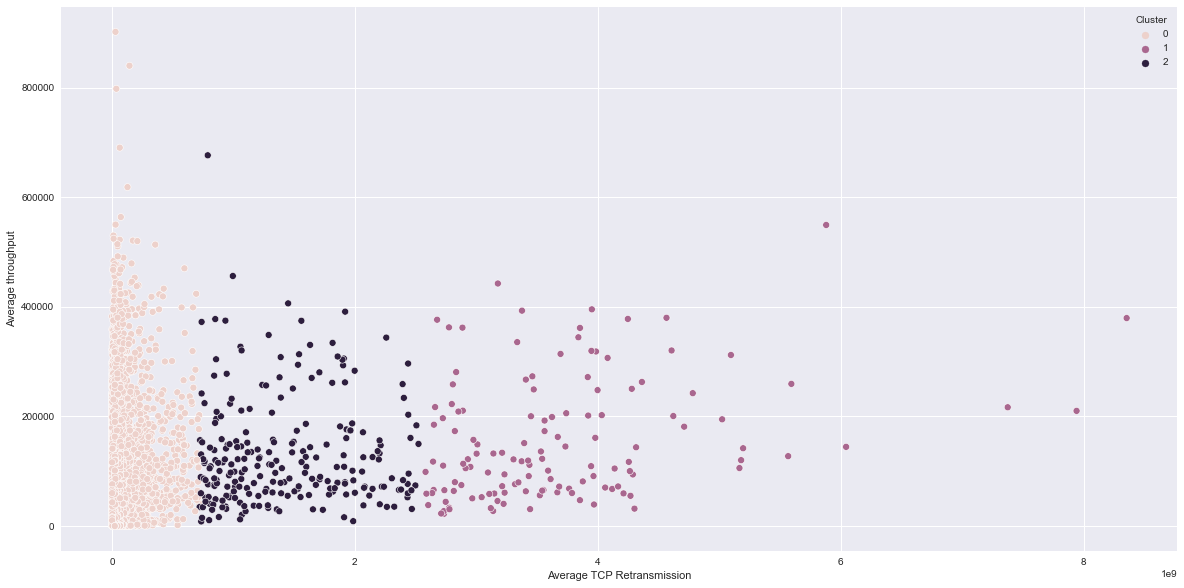

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x="Average TCP Retransmission", y="Average throughput", hue = 'Cluster',  data=transmission_per_user, ax=ax)

In [43]:
transmission_per_user.loc[transmission_per_user["Cluster"] == 0].sort_values(by=["Average TCP Retransmission","Average RTT"], ascending=False)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type,Cluster,Centroid
48016,33662367993.0,717448574.0,3807.0,202494.0,Huawei B528S-23A,0,"[22728545.43361493, 172.10234587798303, 20584...."
36418,33659614930.0,715596728.0,93.0,42331.0,Samsung Galaxy S7 (Sm-G930X),0,"[22728545.43361493, 172.10234587798303, 20584...."
31757,33658623439.0,714204583.0,188.0,177055.0,Huawei B525S-23A,0,"[22728545.43361493, 172.10234587798303, 20584...."
99495,33763539423.0,711967894.0,294.0,106877.0,Huawei B528S-23A,0,"[22728545.43361493, 172.10234587798303, 20584...."
87292,33699154084.0,709113652.0,137.0,52850.0,Huawei B528S-23A,0,"[22728545.43361493, 172.10234587798303, 20584...."
...,...,...,...,...,...,...,...
2163,33607833304.0,143.0,32.0,16853.0,Apple iPhone 5C (A1529),0,"[22728545.43361493, 172.10234587798303, 20584...."
13488,33626357513.0,134.0,40.0,10964.0,Apple iPhone 7 (A1778),0,"[22728545.43361493, 172.10234587798303, 20584...."
96627,33762062356.0,129.0,41.0,32577.0,Apple iPhone 8 (A1905),0,"[22728545.43361493, 172.10234587798303, 20584...."
6327,33614777138.0,128.0,64.0,8654.0,Huawei Ascend Mate7,0,"[22728545.43361493, 172.10234587798303, 20584...."


In [44]:
transmission_per_user.to_csv(data_dir / "transmission_per_user_clustered.csv", index=False)